In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns, numpy as np, matplotlib.pyplot as plt
import time
import numpy as np
import os
import pandas as pd
from skimage import io
import cv2
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

In [ ]:
!unzip '/content/drive/MyDrive/CSE499/Final Models/Selected Models/FinalMerged.zip'

Streaming output truncated to the last 5000 lines.
  inflating: FinalMerged/test/Blast/Blast_0113.jpg  
  inflating: FinalMerged/test/Blast/Blast_0114.jpg  
  inflating: FinalMerged/test/Blast/Blast_0115.jpg  
  inflating: FinalMerged/test/Blast/Blast_0116.jpg  
  inflating: FinalMerged/test/Blast/Blast_0117.jpg  
  inflating: FinalMerged/test/Blast/Blast_0118.jpg  
  inflating: FinalMerged/test/Blast/Blast_0119.jpg  
  inflating: FinalMerged/test/Blast/Blast_0120.jpg  
  inflating: FinalMerged/test/Blast/Blast_0121.jpg  
  inflating: FinalMerged/test/Blast/Blast_0122.jpg  
  inflating: FinalMerged/test/Blast/Blast_0123.jpg  
  inflating: FinalMerged/test/Blast/Blast_0124.jpg  
  inflating: FinalMerged/test/Blast/Blast_0125.jpg  
  inflating: FinalMerged/test/Blast/Blast_0126.jpg  
  inflating: FinalMerged/test/Blast/Blast_0127.jpg  
  inflating: FinalMerged/test/Blast/Blast_0128.jpg  
  inflating: FinalMerged/test/Blast/Blast_0129.jpg  
  inflating: FinalMerged/test/Blast/Blast_0130.j

In [ ]:
root_dir = '/content/FinalMerged'
train_dir = '/content/FinalMerged/train'
valid_dir = '/content/FinalMerged/validation'
test_dir = '/content/FinalMerged/test'
 
save_at = '/content/drive/MyDrive/CSE499/Final Models/Saved Models'

IMG_SIZE = 224
BATCH_SIZE = 32
LOSS_FN = 'CrossEntropyLoss'
OPTIMIZER_LIST = ['adam']
DROPOUT_LIST = [.1]
LEAENING_RATE_LIST = [.001]
EPOCHS = 100

NUM_CLASSES = len(os.listdir(train_dir)) # 5

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.vgg16()
        model.classifier[6] = nn.Sequential(
            nn.Dropout(p=DROPOUT),
            nn.Linear(in_features=model.classifier[6].in_features, out_features=NUM_CLASSES)
        )
        self.base_model = model

    def forward(self, x):
        return self.base_model(x)

In [ ]:
for OPTIMIZER in OPTIMIZER_LIST:
    for DROPOUT in DROPOUT_LIST:
        for LEAENING_RATE in LEAENING_RATE_LIST:
            transform = transforms.Compose([
                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                transforms.ToTensor()
            ])

            train_loader = DataLoader(
                ImageFolder(train_dir,transform=transform),
                batch_size = BATCH_SIZE, shuffle = True
            )

            valid_loader = DataLoader(
                ImageFolder(valid_dir,transform=transform),
                batch_size = BATCH_SIZE, shuffle = True
            )


            model = Model().to(device)


            TRAINABLE_PARAMS = sum(p.numel() for p in model.parameters() if p.requires_grad)


            loss_fn = nn.CrossEntropyLoss()

            if OPTIMIZER == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr = LEAENING_RATE)
            elif OPTIMIZER == 'adam':
                optimizer = optim.Adam(model.parameters(), lr = LEAENING_RATE)
            elif OPTIMIZER == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr = LEAENING_RATE)
            elif OPTIMIZER == 'Adadelta':
                optimizer = optim.Adadelta(model.parameters(), lr = LEAENING_RATE)
            elif OPTIMIZER == 'Adamax':
                optimizer = optim.Adamax(model.parameters(), lr = LEAENING_RATE)



            t_loss = 0
            t_acc = 0
            t_time = 0
            v_acc = 0
            v_time = 0

            best_valid_acc = 0.0
            for epoch in range(EPOCHS):
                train_starts = time.time()
                model.train()
                train_count, correct_preds = 0, 0
                train_loss = 0.
                for i, (images, labels) in enumerate(train_loader):
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    _, preds = torch.max(outputs.data, 1)
                    train_count += labels.size(0)
                    correct_preds += (preds == labels).sum().item()
                    train_loss += loss.item() * labels.size(0)
                train_acc = (correct_preds / train_count) * 100.
                train_loss = train_loss / train_count
                train_ends = time.time()
                train_time = train_ends - train_starts


                valid_starts = time.time()
                model.eval()
                with torch.no_grad():
                    correct_preds, valid_count = 0, 0
                    for images, labels in valid_loader:
                        images = images.to(device)
                        labels = labels.to(device)
                        outputs = model(images)
                        _, preds = torch.max(outputs.data, 1)
                        valid_count += labels.size(0)
                        correct_preds += (preds == labels).sum().item()
                    valid_acc = (correct_preds / valid_count) * 100.

                    PATH = '/content/drive/MyDrive/CSE499/Final Models/Saved Models/compareRiceVGG16.pth'
                    if valid_acc > best_valid_acc:
                        torch.save(model.state_dict(), PATH)
                        best_valid_acc = valid_acc
                        print(valid_acc)
                    
                    valid_ends = time.time()
                    valid_time = valid_ends - valid_starts
                                                
                                                
                    t_loss = train_loss
                    t_acc = train_acc
                    t_time = train_time
                    v_acc = valid_acc
                    v_time = valid_time
                print(f'Epoch: {epoch}, Train_Accuracy: {train_acc:.2f}%, Train_Loss: {train_loss:.2f}, Train_Time: {train_time:.1f}s, Valid_Accuracy: {valid_acc:.2f}%, Valid_Time: {valid_time:.1f}s')
            

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


22.08300704776821
Epoch: 0, Train_Accuracy: 32.14%, Train_Loss: 3.76, Train_Time: 113.0s, Valid_Accuracy: 22.08%, Valid_Time: 23.2s
Epoch: 1, Train_Accuracy: 31.98%, Train_Loss: 1.51, Train_Time: 112.8s, Valid_Accuracy: 22.08%, Valid_Time: 15.6s
Epoch: 2, Train_Accuracy: 31.67%, Train_Loss: 1.52, Train_Time: 112.2s, Valid_Accuracy: 22.08%, Valid_Time: 15.6s
Epoch: 3, Train_Accuracy: 32.39%, Train_Loss: 1.51, Train_Time: 112.3s, Valid_Accuracy: 22.08%, Valid_Time: 15.6s
Epoch: 4, Train_Accuracy: 31.95%, Train_Loss: 1.51, Train_Time: 109.8s, Valid_Accuracy: 22.08%, Valid_Time: 15.6s
Epoch: 5, Train_Accuracy: 32.65%, Train_Loss: 1.51, Train_Time: 109.9s, Valid_Accuracy: 22.08%, Valid_Time: 15.6s
Epoch: 6, Train_Accuracy: 31.82%, Train_Loss: 1.51, Train_Time: 109.6s, Valid_Accuracy: 22.08%, Valid_Time: 15.6s
Epoch: 7, Train_Accuracy: 31.98%, Train_Loss: 1.51, Train_Time: 109.9s, Valid_Accuracy: 22.08%, Valid_Time: 15.6s
Epoch: 8, Train_Accuracy: 32.01%, Train_Loss: 1.51, Train_Time: 110.8s

In [ ]:
model = Model().to(device)

PATH = '/content/drive/MyDrive/CSE499/Final Models/Saved Models/compareRiceVGG16.pth'

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

test_loader = DataLoader(
    ImageFolder(test_dir,transform=transform),
    batch_size = BATCH_SIZE, shuffle = True
)

model.load_state_dict(torch.load(PATH))
model.eval()

with torch.no_grad():
    all_preds = []
    all_labels = []
    correct_preds, valid_count = 0, 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs.data, 1)
        all_preds.append(preds)
        all_labels.append(labels)
        valid_count += labels.size(0)
        correct_preds += (preds == labels).sum().item()
    valid_acc = (correct_preds / valid_count) * 100.
    print(f'validation accuracy: {valid_acc}')

validation accuracy: 22.11764705882353


In [ ]:
y_pred = []
for x in all_preds:
    for i in x:
        y_pred.append(i.detach().cpu().numpy().item())

y_pred = np.array(y_pred)

In [ ]:
y_true = []
for x in all_labels:
    for i in x:
        y_true.append(i.cpu().item())

y_true = np.array(y_true)

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
cm

array([[188,   0,   0,   0,   0],
       [163,   0,   0,   0,   0],
       [187,   0,   0,   0,   0],
       [149,   0,   0,   0,   0],
       [163,   0,   0,   0,   0]])

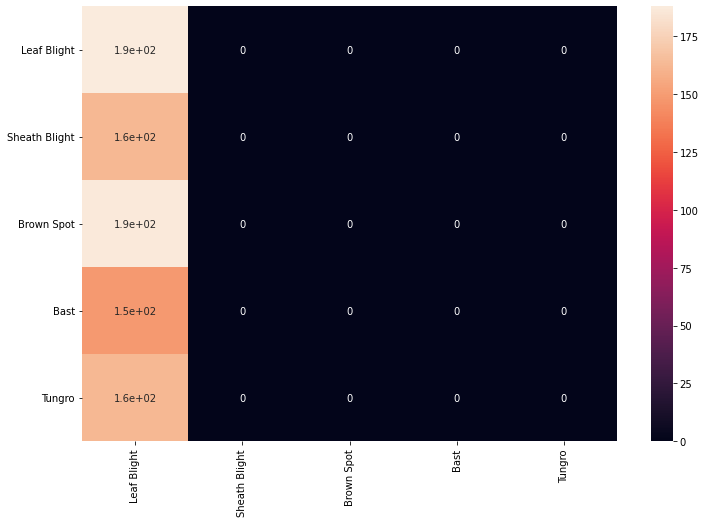

In [ ]:
plt.figure(figsize=(12, 8))
classes = [
    'Leaf Blight',
    'Sheath Blight',
    'Brown Spot',   
    'Bast',
    'Tungro'      
]
fig = sns.heatmap(cm, annot=True)
fig.set_xticklabels(classes, rotation = 90)
fig.set_yticklabels(classes, rotation = 0)
plt.show()

In [ ]:
accuracy_score(y_true, y_pred)

0.2211764705882353

In [ ]:
precision_score(y_true, y_pred, average='macro')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.04423529411764706

In [ ]:
recall_score(y_true, y_pred, average='macro')

0.2

In [ ]:
f1_score(y_true, y_pred, average='macro')

0.07244701348747593